Current Working Directory: /content
File not found. Please enter the full path to LoanApprovalPrediction.csv: /content/LoanApprovalPrediction (1).csv
    Loan_ID  Gender Married Dependents     Education Self_Employed  \
0  LP001002    Male     Yes          0      Graduate            No   
1  LP001003    Male      No          1      Graduate            No   
2  LP001005    Male     Yes          0      Graduate           Yes   
3  LP001006    Male     Yes          0  Not Graduate            No   
4  LP001008  Female      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                  0         116               360   
1             4583               1508         128               360   
2             3000                  0          66               360   
3             2583               2358         120               360   
4             6000                  0         141               360   

  

<Figure size 1800x3600 with 0 Axes>

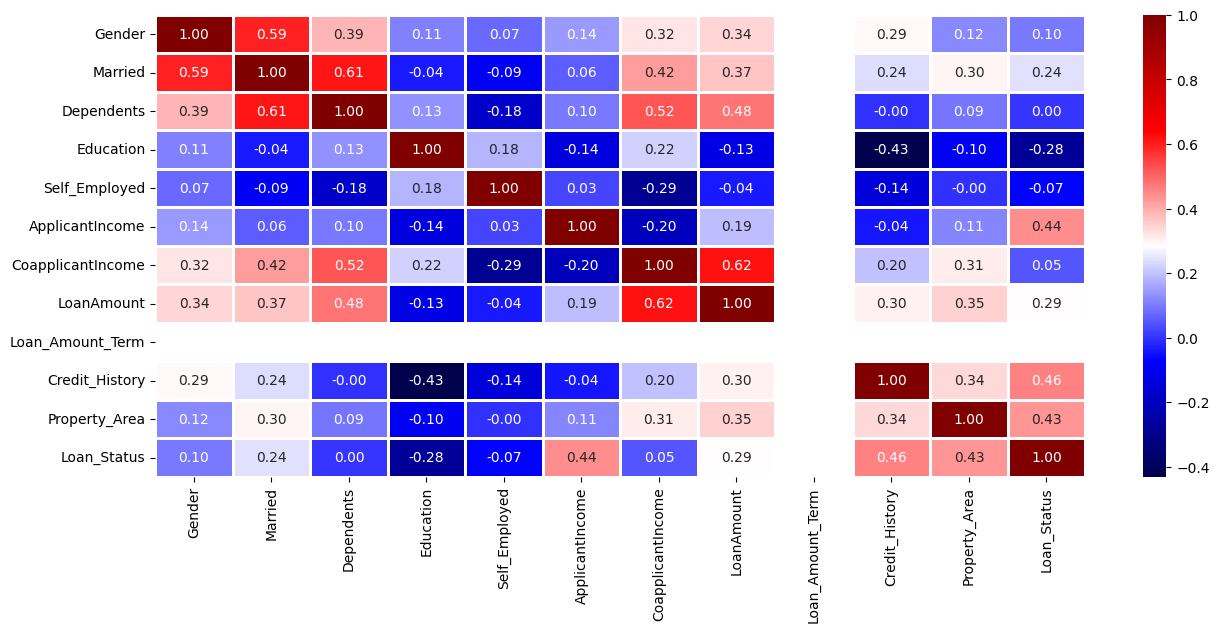

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Load dataset
print("Current Working Directory:", os.getcwd())
file_path = 'LoanApprovalPrediction.csv'  # Define the file path

# Check if the file exists in the current working directory
if not os.path.exists(file_path):
    # If not, ask the user to provide the full file path
    file_path = input("File not found. Please enter the full path to LoanApprovalPrediction.csv: ")

data = pd.read_csv(file_path)  # Read the CSV file using the updated file path
print(data.head())  # Display first 5 rows of the dataset


# Dropping unnecessary columns
data.drop(['Loan_ID'], axis=1, inplace=True)

# Handle missing values
for col in data.columns:
    # Check if the column is numeric before calculating the mean
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col] = data[col].fillna(data[col].mean())
    else:
        # Handle missing values for categorical columns (e.g., using mode)
        data[col] = data[col].fillna(data[col].mode()[0])

# Encode categorical variables
label_encoder = preprocessing.LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = label_encoder.fit_transform(data[col])

# Visualize categorical variables
plt.figure(figsize=(18, 36))
for index, col in enumerate(data.select_dtypes(include='object').columns, start=1):
    y = data[col].value_counts()
    plt.subplot(len(data.select_dtypes(include='object').columns), 1, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y, palette=["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32"])
    plt.xlabel(col, fontsize=15)
    plt.ylabel('Count', fontsize=15)

# Heatmap visualization for correlations
plt.figure(figsize=(15, 6))
sns.heatmap(data.corr(), cmap='seismic', fmt='.2f', linewidths=2, annot=True)

# Split dataset
X = StandardScaler().fit_transform(data.drop('Loan_Status', axis=1))
Y = data['Loan_Status']
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1, stratify=Y_temp)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

# Train models
models = [KNeighborsClassifier(n_neighbors=3), RandomForestClassifier(random_state=7), SVC(), LogisticRegression()]
for model in models:
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)
    print(f"{model.__class__.__name__} Accuracy: {accuracy_score(Y_train, Y_pred) * 100:.2f}%")

# Hyperparameter tuning for RandomForestClassifier
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=7), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_

# Evaluate best model
Y_pred = best_model.predict(X_test)
Y_pred_proba = best_model.predict_proba(X_test)[:, 1]
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
auc = roc_auc_score(Y_test, Y_pred_proba)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc)